# Clustering using Hidden Markov Model 

### Import packages

In [1]:
from simpl_eeg import raw_voltage, eeg_objects, connectivity, topomap_2d, topomap_3d_brain, topomap_3d_head
from hmmlearn import hmm
import mne
import seaborn as sns
import numpy as np
import pandas as pd

### Plotting function

In [9]:
# Adapted from MDS 563 lecture 2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

def plot_pca_clusters(data, labels):
    """
    Carries out dimensionality reduction on the data for visualization
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        data=principal_comp, columns=["pca1", "pca2"], index=data.index
    )
    pca_df["cluster"] = labels
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10"
    )
    plt.show()

### Read in the data

In [2]:
raw_full = mne.io.read_raw_eeglab('../../data/927/fixica.set')

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-2-788e4d9e6196>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab('../../data/927/fixica.set')


In [3]:
entire_df = raw_full.to_data_frame()

### Data preprocessing

In [4]:
# to get average chunked data

cleaned_df = entire_df[(entire_df.T != 0).any()] # drop rows where all values are zero

sliced_df = entire_df.iloc[:5540000]
avg_chunked_list = []
for i in range(554):
    avg_sliced_array = sliced_df.iloc[i*10000:i*10000+10000, 1:].mean().to_numpy() # separate the data into chunks of per 5 seconds and get the average
    avg_chunked_list.append(avg_sliced_array)
avg_chunked_array=np.array(avg_chunked_list) 

In [ ]:
# to get chunk data, not used since file is too large and the operation runs out of memory

# avg_df = entire_df.groupby("time").mean().reset_index()
# entire_list = []
# for i in range(541):
#     sliced_array = avg_df.iloc[i*10000:i*10000+10000, 1:].to_numpy().reshape(-1)
#     entire_list.append(sliced_array)
# entire_array_chunk = np.array(entire_list)

# entire_array_chunk=np.float32(entire_array_chunk)

### Hyperparameter tuning

In [14]:
tune_comp = {}
model_list = []
for n_comp in range(5, 21, 1):
    model = hmm.GaussianHMM(n_components=n_comp)
    model_list.append(model)
    model.fit(avg_chunked_array)
    result = model.decode(avg_chunked_array, algorithm="viterbi")
    tune_comp[n_comp] = result[0]

In [15]:
maximum = max(tune_comp, key=tune_comp.get) 
print(f"The best # of cluster is {maximum}, with log probability of {tune_comp[maximum]}")

The best # of cluster is 19, with log probability of -1529.202425534449


In [22]:
optimized_model = model_list[14]
optimized_model

GaussianHMM(n_components=19)

In [30]:
optimized_result = optimized_model.decode(avg_chunked_array, algorithm="viterbi")

In [31]:
for index, labels in enumerate(optimized_result[1]):
    sliced_df.loc[index*10000:index*10000+10000, 'cluster'] = labels

C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


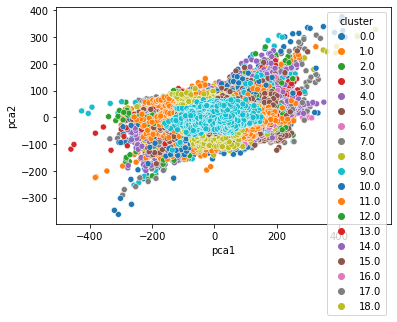

In [32]:
plot_pca_clusters(sliced_df.iloc[:,1:20], sliced_df.cluster)